<h2> Predict Loan Defaulters Part 3</h2>
This notebook will take as input the cleaned training/test data sets from the previous notebook (link below): <br>
Having the dataset pre-processed, we will now focus on model selection/building

<h3>Notebook Setup</h3>

<ol>
  <li>Create Transformers to handle diffrents processing needs of our dataset </li>
  <li>Apply Transformation to our Dataset</li>
  <li>Perform Prediction of Loan Defaulters</li>
  <li>Model Interpretation</li>
</ol> 

[Github Link to orginal notebooks and helper files](https://github.com/marcelkore/Predict_Good_Loans) 

[Part 1 - Exploratory Notebook](https://nbviewer.jupyter.org/gist/marcelkore/0115941837b398617e535024b4c8ba56)<br>
[Part 2 - Cleaning Notebok](https://nbviewer.jupyter.org/gist/marcelkore/242cacb443fa015dda23dcca7e3378f3)

### Steps in the process
1. [Scaling Transformer](#scaling)
2. [Skew Transformer](#skew)
3. [Logistic Regression](#baseline_model)
4. [LightGBM_Model](#lgb_classifier)
5. [Feature Importance](#feature_importance)


In [2]:
# Standard Libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


# category encoding
import category_encoders as ce

#helper functions
import helper_functions as helpers
import modeling_helper_functions as mhf
import parameter_tuning_helper as pt
from skew_autotransform import skew_autotransform

# hyper-parameter tuning
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from yellowbrick.classifier import ClassificationReport
from hyperopt.fmin import fmin

#sklearn libraries
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc
import scikitplot as skplt
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, precision_score

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest, f_classif,chi2
from sklearn import metrics

# feature importance
import shap

# classification algorithms
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression

import itertools
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

import os

from datetime import datetime
from datetime import date

# Viz Libraries
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [3]:
from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"
# scientific notation
pd.options.display.float_format = '{:.2f}'.format

In [4]:
import psutil
print('Total number of cpus detected: {}.'.format(psutil.cpu_count()))
print('Total size of system memory: {:.5f} gb.'.format(psutil.virtual_memory().total / 1e9))

Total number of cpus detected: 16.
Total size of system memory: 68.40692 gb.


In [5]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.22.1.


### Data Dictionary
<h5> We will load the data dictionary to help us inspect each feature definition as we proceed </h5>

In [57]:
# load training data
train_set = pd.read_csv('lc_train_cleaned_woe_mean.csv')

# load test data
test_set = pd.read_csv('lc_test_cleaned_woe_mean.csv')

print('Train Set Shape: {}, Test Set Shape: {}'.format(train_set.shape,test_set.shape))

Train Set Shape: (487353, 19), Test Set Shape: (146206, 19)


In [58]:
# peek at the data 
train_set.head()

,open_act_il,open_rv_24m,int_rate,il_util,total_cu_tl,fe_int_rate + open_acc,fico_score_neg_term,term,fe_interest_paid_monthly,initial_list_status,open_rv_12m,inq_last_12m,fico_score,percent_bc_gt_75,bc_util,revol_util,inq_fi,bc_open_to_buy,loan_status
0,1.00,0.00,7.96,74.00,0.00,10.96,144.00,36,2122.92,0.67,0.00,2.00,712.00,0.00,25.41,25.41,1.00,9398.00,1
1,1.00,2.00,17.09,88.00,0.00,28.09,240.00,60,43873.96,0.67,0.00,5.00,732.00,25.00,42.91,42.91,3.00,20397.00,1
2,1.00,0.00,15.59,66.00,0.00,20.59,144.00,36,8867.65,0.46,0.00,1.00,667.00,100.00,105.19,54.09,0.00,0.00,1
3,0.00,0.00,18.92,71.40,1.60,30.92,240.00,60,31536.46,0.46,0.00,0.00,682.00,100.00,94.12,82.50,0.00,1153.00,0
4,0.00,3.00,10.75,71.40,0.00,14.75,144.00,36,13795.83,0.67,1.00,2.00,707.00,66.69,88.31,82.12,0.00,842.00,1


In [8]:
# code below to reduce memory of the dataset
train_set = helpers.reduce_mem_usage(train_set)
test_set = helpers.reduce_mem_usage(test_set)

Memory usage of dataframe is 70.65 MB
Memory usage after optimization is: 18.59 MB
Decreased by 73.7%
Memory usage of dataframe is 21.19 MB
Memory usage after optimization is: 5.58 MB
Decreased by 73.7%


In [9]:
# features retained after feature selection in previous notebook
train_set.columns

Index(['open_act_il', 'open_rv_24m', 'int_rate', 'il_util', 'total_cu_tl',
       'fe_int_rate + open_acc', 'fico_score_neg_term', 'term',
       'fe_interest_paid_monthly', 'initial_list_status', 'open_rv_12m',
       'inq_last_12m', 'fico_score', 'percent_bc_gt_75', 'bc_util',
       'revol_util', 'inq_fi', 'bc_open_to_buy', 'loan_status'],
      dtype='object')

In [10]:
# setting up this global variable to help toggle different settings during the train phase (not recommended)
CPU_COUNT = -1
CROSS_VAL_COUNT = 10
SCORING_METRIC = 'f1_weighted'
MAX_EVALUATIONS =250

### Categorical Features

In [11]:
# Extract categorical features from the dataframe
# Remove loan status from overall list
cat_features= np.where(train_set.drop("loan_status", axis=1).apply(pd.Series.nunique) < 10)[0].tolist()
cat_names = train_set.drop("loan_status", axis=1).columns[cat_features].tolist()

# change dataypes for features into category for both test and train set
train_set[cat_names] = train_set[cat_names].astype('category')
test_set[cat_names] = test_set[cat_names].astype('category')

In [12]:
# list of categorical features in our dataset. 
cat_names

['fico_score_neg_term', 'term', 'initial_list_status']

<h2> <b> Scaling </b> </h2>
<a id="Scaling"></a>
<p>
Our data contains attributes with varying scales. As Brownlee (2019) points out, many learning algorithms can benefit from rescaling attributes to all have <br>
the same scale. This processing is useful for algorithms used in core machine learning that use gradient boosting or distance measures like k-nearest neighbors.
</p>
    
Link below has a comparison of the different algorithms and which ones need scaling and which ones dont. 
</p>  
<p> <a href="https://www.dataschool.io/comparing-supervised-learning-algorithms/"> Comparing supervised learning algorithms </p>
    
    

<h3> Standardize Scaler </h3>

`Standardization` is a useful technique that transforms attributes with a non=gaussian distribution and different means and standard deviations to <br>
a standard Gaussian distribution with a mean of 0 and a standard deviation of 1. 

`Unsupervised learning algorithms`, in practice, more often benefit from standardization than from normalization; standardization is also preferred <br>
for a feature if the values this feature takes are distributed close to a normal distribution (so-called bell curve); again, standardization  <br>
is preferred for a feature if it can sometimes have extremely high or low values (outliers); this is because normalization will “squeeze” the normal <br>
values into a very small range; in all other cases, normalization is preferable.

In [13]:
class ScalingTransformer(TransformerMixin,BaseEstimator):
    """
    This transformer takes in a dataframe and performs
    standardization using the standard scaler library
    
    Input: Dataframe
    -----------------------------------
    Process: Using the data types, it will scale all available
    non-category features
    ------------------------------------
    Output: Dataframe with scaled numeric features
    """
       
    def __init__(self):
        pass
    
    def fit(self,df,y=None):
        return self
    
    def transform(self,df):
        scaler = StandardScaler()
        column_list = df.columns
        numeric_to_scale = df.select_dtypes(exclude='category').columns.tolist()
        category_to_scale = df.select_dtypes(include='category').columns.tolist()
        
        df[numeric_to_scale] = scaler.fit_transform(df[numeric_to_scale].to_numpy())
               
        return df

## Skew Transformer
<a id="skewed"></a>
In the exploratory notebook, we determined that a majority of the features were significantly skewed. <br>
The transformer below transforms skewed features above a defined threshold in order to increase the predictive <br>
power of our model.

In [14]:
class SkewTransformer(TransformerMixin,BaseEstimator):
    """
    This transformer uses a function that will accept a pandas dataframe
    and auto-transforms columns that exceeds threshold value
    
    #  -  Offers choice between boxcox or log / exponential transformation
    #  -  Automatically handles negative values
    # Source: https://datamadness.github.io/Skewness_Auto_Transform
    
    Input: Dataframe
    -----------------------------------
    Process: Using the data types, it will scale all available
    ------------------------------------
    Output: Dataframe with skewed features above a threshold converted
    
    """
       
    def __init__(self):
        pass
    
    def fit(self,df,y=None):
        return self

    def transform(self,df):
        
        exclude_columns = df.select_dtypes(include='category').columns.tolist()
        
        df = skew_autotransform(df.copy(deep=True), plot = False, 
                                   exp = True, threshold = 0.7, exclude = exclude_columns)
                     
        return df

### **Create Feature Matrix and Labels**

In [15]:
# drop our target feature
X_train = train_set.drop('loan_status', axis=1)
# save our target feature in a y variable
y_train = train_set.loan_status

# drop our target feature
X_test= test_set.drop('loan_status', axis=1)
# save our target feature in a y variable
y_test = test_set.loan_status

# review splits
print("X_train: {}, y_train: {}".format(X_train.shape,y_train.shape))

# review splits
print("X_test: {}, y_test: {}".format(X_test.shape,y_test.shape))

X_train: (487353, 18), y_train: (487353,)
X_test: (146206, 18), y_test: (146206,)


<h2> <b> Performance Metrics</b> </h2>
<a id="performance"></a>
We have an imbalanced dataset and the minority class are the loan defaulters (positive class represented by 0). One way to deal with imbalanced class <br>
proportions during model fitting is to assign a larger penalty to wrong predictions on the minority class. Via scikit-learn, adjusting such a penalty <br>
is as convenient as setting the class_weight parameter to class_weight='balanced', which is implemented for most classifiers. <br>

Other popular strategies for dealing with class imbalance include up-sampling the minority class, down-sampling the majority class, and the generation <br>
of synthetic training samples. Unfortunately, there's no universally best solution, no technique that works best across different problem domains. <br>
Thus, in practice, it is recommended to try out different strategies on a given problem, evaluate the results, and choose the technique that seems most appropriate.

Based on the class imbalance present in the dataset, we know that accuracy is not a good measure.To choose a suitable metric, we have to step back and look at the business problem <br>
we are trying to solve. This is a bank and the problem an imaginary VP has given us is to solve for loan defaulters. These are folks who take out loans and are <br>
not interested/ or are likely to default on the loan. The bank wants to minimize the likelihood of giving a loan to such people. We have more observations of people <br>
who `do not` default on their loan than people `who do`. <br>

Because of this fact, selecting all observations as `non defaulting` would lead to a higher accuracy which would be result in a useless model. <br>

KiwiDamien over at Stacked Turtles really helped me understand the different metrics. I'd recommend his blog as he explains concepts very clearly in my opinion. <br>
[Stacked Turtles](https://kiwidamien.github.io/).


We will focus on two metrics for this problem; Precision and Recall. <br>

`Precision:`  Out of all the positive cases identified, what fraction is actually positive<br>
We have to first define our positive case. In this instance, it is `non-defaulters`. If we assume 70% is our precision, it means that out of  all the loans approved <br>
(non-defaulters detected), 70% are actually non-defaulters while 30% of are defaulters. What this means is that the 30% of folks approved have the potential of costing Lending <br>
Club some money by defaulting on their loans.<br>
Precision = TP/TP+FP

`Recall:`  Out of all the positive cases identified, what fraction is actually positive i.e., what fraction are actually loan defaulters <br>
If we assume our model achieves a 70% recall, it means that 70% of `non-defaulters` are identified by the system for loan approval while the system would be <br>
rejecting 30% of `non-defaulters` who would pay back our loans and earn Lending Club interest. Think of these are missed opportunities for Lending Club to make money. <br>
Precision = TP/TP+FN

<br>
So for Lending Club, a decision has to be made as to which metric is important to them?  Is it important to ensure that defaulters are not <br>
issued loans (low precision) and thus cost them money at the end or is it important that we don't loose good business (low recall). 
<br>
<br>

They can also decide that they want to optimize for both. This can be achieved by using the `F1 Score` which is the harmonic mean between <br>
precision and recall. This metric will account for both the False Positives and False Negatives in the dataset and help the business achieve a happy medium. <br>

F1 Score = 2*(Recall * Precision) / (Recall + Precision) <br>

For our purpose, we will assume that the priority is getting a `F1 Score` and so we will optimize for that.     

<h2> <b> Baseline Logistic Regression</b> </h2>
<a id="baseline_model"></a>

Lets create a baseline prediction that we can compare the results with. We will set our class weight to balanced since we know we have an imbalanced dataset <br>
Class weight set to balanced assigns a larger penalty on the minority class. There is no universal recommnded solution other than attempting different strategies for each problem

In [16]:
# Logistic Regression
logistic_r_model = LogisticRegression(class_weight='balanced',n_jobs=CPU_COUNT)

In [17]:
# parameter tuning
C = np.logspace(0, 4, 10)
solver = ['lbfgs','liblinear']
param_grid = {'C': C, 'solver' : solver}

lr_grid = GridSearchCV(estimator=logistic_r_model,
                       param_grid=param_grid,
                       cv=CROSS_VAL_COUNT,
                       n_jobs=CPU_COUNT,
                       scoring=SCORING_METRIC)

lr_grid = lr_grid.fit(X_train, y_train)
print('Best parameters : {}'.format(lr_grid.best_params_))

# Logistic Regression
logistic_r_model = LogisticRegression(class_weight='balanced',n_jobs=CPU_COUNT,
                                      C=lr_grid.best_params_['C'], solver=lr_grid.best_params_['solver'])

logistic_r_model

Best parameters : {'C': 59.94842503189409, 'solver': 'liblinear'}


LogisticRegression(C=59.94842503189409, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
# create a pipeline for our logistic regression
logistic_pipeline= Pipeline(steps=[
    ('scaling_transformer', ScalingTransformer()),
    ('skew_transformer', SkewTransformer()),
    ('logistic_regression', logistic_r_model)
])

The function below runs a 10 fold stratified cross-validation on the dataset.

In [19]:
# train logistic model
mhf.train_model(logistic_pipeline,
                X_train,y_train,
                scoring_metric=SCORING_METRIC,
                number_of_folds=CROSS_VAL_COUNT,
                n_jobs=CPU_COUNT)

Cross Validation f1_weighted Training Score for Pipeline is 75.573
Time elapsed (hh:mm:ss.ms) 0:00:25.094053


In [20]:
logistic_pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaling_transformer', ScalingTransformer()),
                ('skew_transformer', SkewTransformer()),
                ('logistic_regression',
                 LogisticRegression(C=59.94842503189409,
                                    class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=-1, penalty='l2',
                                    random_state=None, solver='liblinear',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

In [21]:
# generate predictions
lr_ypred = logistic_pipeline.predict_proba(X_test)[:,1]

In [22]:
# we will use the true postive and false positive rates to determine the threshold 
threshold_lr = helpers.define_optimal_threshold(logistic_pipeline,X_test,y_test,plot=False)

optimal threshold:0.67


In [23]:
train_set.loan_status.value_counts()

1    294902
0    192451
Name: loan_status, dtype: int64

In [24]:
# here we use the threshold above of 0.67 to determine which
# values qualify for our positive class
lr_ypred = np.where(lr_ypred > threshold_lr, 1, 0)

In [25]:
average_precision = average_precision_score(y_test, lr_ypred)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.76


## **LightGBM**
<a id="lgb_classifier"></a>

### **Apply Light Gradient Boosting Model Classifier with Hyperopt Parameter Tuning**

LightGBM is a gradient boosting framework that uses a tree based learning algorithms with the following advantages <br><p>
* Faster training speed and higher efficiency.
* Lower memory usage.
* Better accuracy.
* Support of parallel and GPU learning.
* Capable of handling large-scale data.
    
   
>    LightGBM Documentation - https://lightgbm.readthedocs.io/en/latest/


<p> Several model tuning methods exist today with the most popular being gridsearch and randomsearch <br>
    I will be using HyperOpt library which uses bayesian framework that uses past trials to calculate the optimal <br> 
    parameters for a given model. The main difference between hyperopt and other methods is that the former methods <br>
    do not "learn" from each iteration on the data. <p>
        
>   More details here: https://hyperopt.github.io/hyperopt/

In [26]:
from yellowbrick.model_selection import ValidationCurve
import matplotlib as mpl
from cycler import cycler
import lightgbm as lgb

In [27]:
lgbm_optimized = pt.lgb_tuning(X_train, y_train,
                               X_test,y_test,
                               cpu_count=CPU_COUNT,
                               scoring=SCORING_METRIC,
                               cv_value=CROSS_VAL_COUNT,
                               max_evals_num=MAX_EVALUATIONS,
                               categorical_features=cat_features,
                               device_type='CPU'
                              )

lgbm_optimized

100%|██████████| 250/250 [1:18:38<00:00, 18.88s/it, best loss: 0.1233763199142709] 


Time elapsed (hh:mm:ss.ms) 1:18:38.858201


LGBMClassifier(boosting_type='gbdt', categorical_list=0,
               class_weight='balanced', colsample_bytree=0.3658400654273483,
               device_type='CPU', feature_fraction=0.9658717823794165,
               importance_type='split', learning_rate=0.084, max_depth=6,
               min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.06347389254867175, n_estimators=100, n_jobs=-1,
               num_leaves=33, objective='binary', random_state=None,
               reg_alpha=0.7182506922818552, reg_lambda=0.3864269238536103,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [28]:
# create lightgbm pipeline
lightgbm_pipeline= Pipeline(steps=[
    ('scaling_transformer', ScalingTransformer()),
    ('skew_transformer', SkewTransformer()),
    ('LightGBM', lgbm_optimized)
])

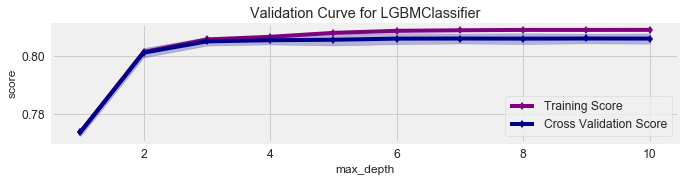

In [29]:
# the plot below validates our tuning where we got a optimal depth of 6
# from the plot below, we can see it pretty much flattens out between the 5th and 6th values
helpers.yellow_brick_validation_curve(lgbm_optimized, 
                                      X_train,y_train,
                                      CPU_COUNT,
                                      CROSS_VAL_COUNT,
                                      "max_depth",
                                      SCORING_METRIC
                                     )

In [30]:
# load preprocessing transformers
lightgbm_pipeline= Pipeline(steps=[
    ('scaling_transformer', ScalingTransformer()),
    ('skew_transformer', SkewTransformer()),
    ('LightGBM', lgbm_optimized)
])

In [31]:
# train lightgbm model
mhf.train_model(lightgbm_pipeline,
                X_train,y_train,
                scoring_metric=SCORING_METRIC,
                number_of_folds=CROSS_VAL_COUNT,
                n_jobs=CPU_COUNT)

Cross Validation f1_weighted Training Score for Pipeline is 80.591
Time elapsed (hh:mm:ss.ms) 0:00:22.564149


In [32]:
lightgbm_pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaling_transformer', ScalingTransformer()),
                ('skew_transformer', SkewTransformer()),
                ('LightGBM',
                 LGBMClassifier(boosting_type='gbdt', categorical_list=0,
                                class_weight='balanced',
                                colsample_bytree=0.3658400654273483,
                                device_type='CPU',
                                feature_fraction=0.9658717823794165,
                                importance_type='split', learning_rate=0.084,
                                max_depth=6, min_child_samples=20,
                                min_child_weight=0.001,
                                min_split_gain=0.06347389254867175,
                                n_estimators=100, n_jobs=-1, num_leaves=33,
                                objective='binary', random_state=None,
                                reg_alpha=0.7182506922818552,
                               

In [33]:
# generate predictions
# lgb_ypred = lightgbm_pipeline.predict(X_test)
lgb_ypred = lightgbm_pipeline.predict_proba(X_test)[:,1]

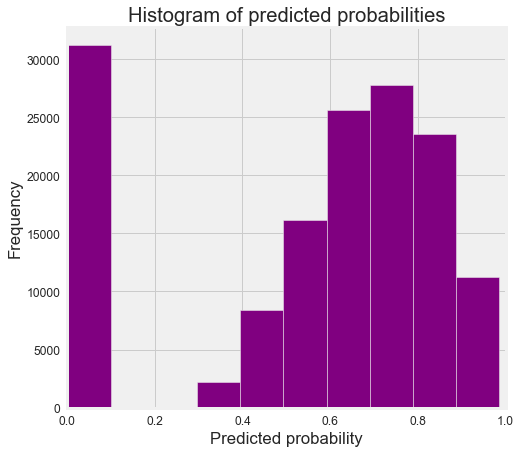

In [34]:
helpers.plot_predicted_probabilities(lgb_ypred)

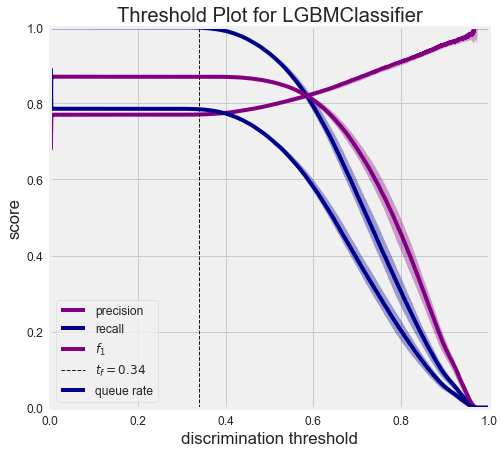

In [35]:
# Visualization Threshold 
helpers.plot_optimal_threshold(lightgbm_pipeline,X_train,y_train)

In [36]:
# we will use the true postive and false positive rates to determine the threshold 
threshold_lgb = helpers.define_optimal_threshold(lightgbm_pipeline,X_test,y_test,plot=False)

optimal threshold:0.51


In [37]:
lgb_ypred = np.where(lgb_ypred > threshold_lgb, 1, 0)

In [38]:
average_precision = average_precision_score(y_test, lgb_ypred)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.78


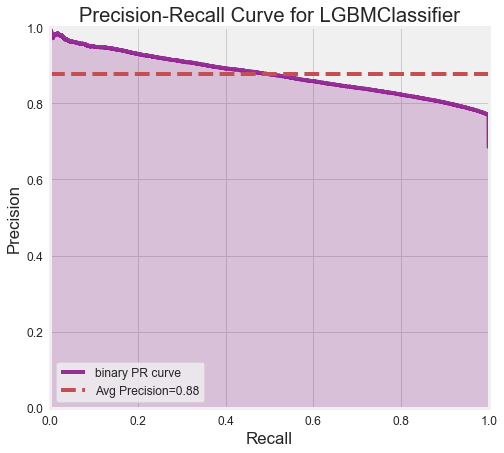

In [39]:
mhf.plot_precision_recall_curve_1(X_train,y_train, X_test,y_test, lightgbm_pipeline)

In [54]:
from sklearn.metrics import matthews_corrcoef

In [55]:
matthews_corrcoef(y_test, lgb_ypred)

0.5973668298812819

A precision recall curve shows precision vs recall at various probability thresholds that can be used to judge predictions. The red <br>
dotted line represents the baseline model where we want our curve to appear above the line. 

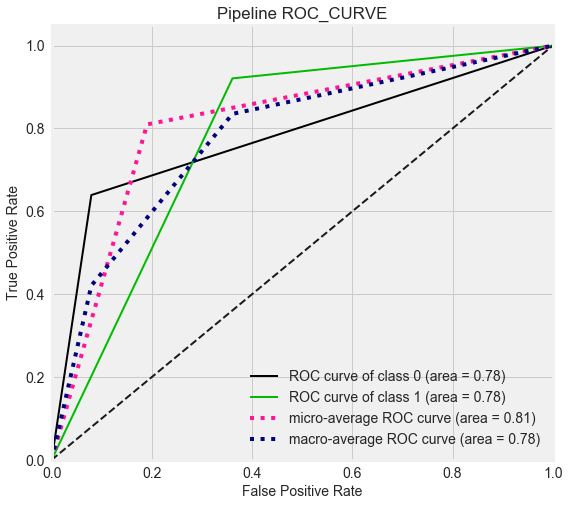

In [40]:
mhf.plot_roc_auc_curve(lgb_ypred,y_test,model=lightgbm_pipeline)

While we are optimizing for the f1 score, we can get a sense of how the model is doing using another available metric called the ROC curve <br>
This metric allows us to visualize the trade-off between sensitivity and specificity. The dotted black line represents a baseline value where anything lower <br>
than that is considered a worse than guessing model. 

The plot below helps us determine two things: If the model is overfitting or underfitting and subsequently the number of training examples <br>
required to achieve an acceptable results with an increase in performance. 

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

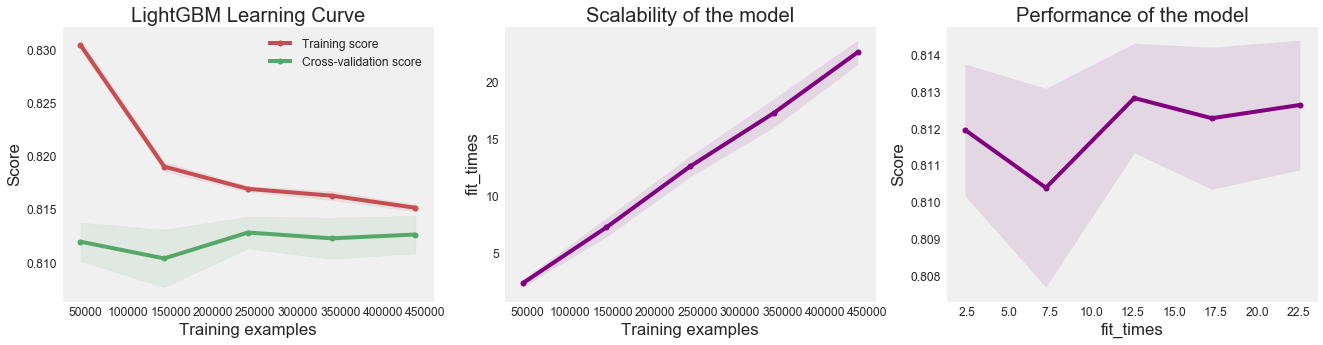

In [41]:
helpers.plot_learning_curve(lightgbm_pipeline,
                            "LightGBM Learning Curve",X_train,y_train,cv=CROSS_VAL_COUNT,n_jobs=CPU_COUNT)

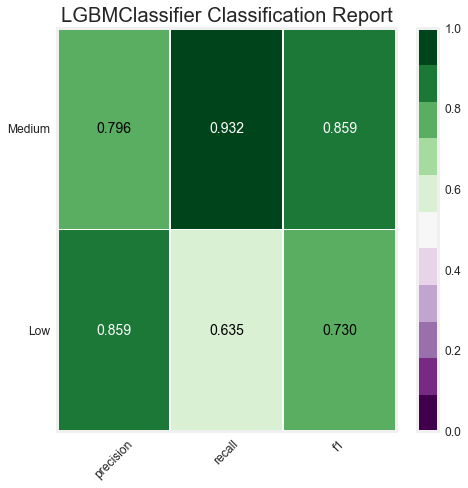

In [42]:
mhf.visual_model_selection(X_train,y_train, lightgbm_pipeline)

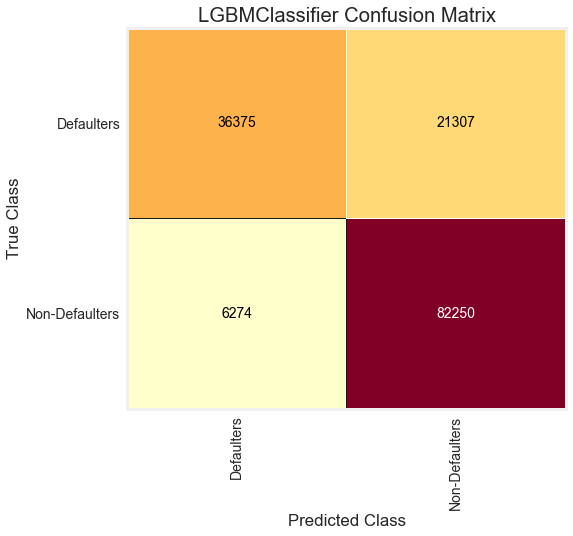

In [43]:
mhf.plot_confusion_matrix(X_train,y_train,
                          X_test, y_test,
                          model=lightgbm_pipeline,
                          encoder={0:'Defaulters', 1: 'Non-Defaulters'})

A confusion matrix helps easily identify the performance of the difference items we are predicting. From the above plot <br>
we can determine that model is performing well with False Negatives while struggling with False Positives (Type 1 and Type 2 erros). 

### **Evaluate on hold-out Test Set**
<a id="holdouttest"></a>

In [44]:
test_set_2019 = pd.read_csv('lc_hold_out_test_woe_mean.csv')

# we loose our categorical features during the export from previous notebook
test_set_2019[cat_names] = test_set_2019[cat_names].astype('category')


# split test set into features and target
X_test_2019 = test_set_2019.drop('loan_status', axis=1)
y_test_2019 = test_set_2019.loan_status

# review splits
print("X_test: {}, y_test: {}".format(X_test_2019.shape,y_test_2019.shape))

X_test: (146206, 18), y_test: (146206,)


In [45]:
# make a prediction using lightGBM classifier
lgb_ypred = lightgbm_pipeline.predict_proba(X_test_2019)[:,1]
lgb_ypred = np.where(lgb_ypred > threshold_lgb, 1, 0)

# make a prediction  using Logistic Regression
lr_ypred = logistic_pipeline.predict_proba(X_test_2019)[:,1]
lr_ypred = np.where(lr_ypred > threshold_lr, 1, 0)

In [246]:
from sklearn.metrics import matthews_corrcoef

In [56]:
# Logistic Regression Score
matthews_corrcoef(y_test, lr_ypred )

# LightGBM Score
matthews_corrcoef(y_test, lgb_ypred)

0.5079854039751314

0.5973668298812819

### LightGBM Score
We see below how our LightGBM model performs on the hold-out test set. 

In [46]:
average_precision = average_precision_score(y_test_2019, lgb_ypred)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.78


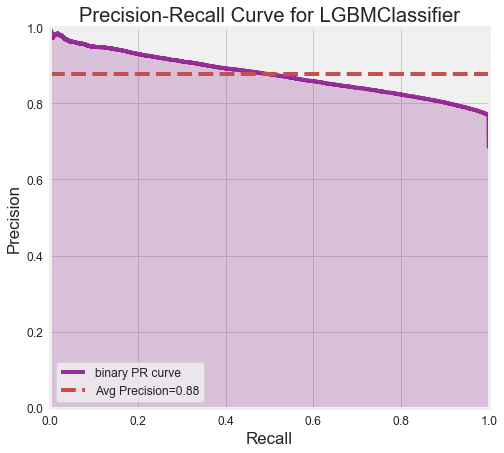

In [47]:
mhf.plot_precision_recall_curve_1(X_train,y_train, X_test_2019,y_test_2019, lightgbm_pipeline)

## **Feature Importance**

Feature Importance is particularly useful in highlighly regualted industries like banking. Society and powers that be need to <br>
know that you are not declining their loan application due to the color of their hair or something arbitary thats out of their control. <br>

This is partly the reason why I choose such a few # of features. I have seen papers where higher metrics are achieved but the models use <br>
all the features available. First of all, if the model were to make it in production, performance would be an issue. Secondly, 100 plus features <br>
becomes complicated when you need to explain  why a loan was declined. 

An additional topic is whether to perform feature importance on the test set or the training set. Christoph (2019) provides the pro's and cons which go <br>
something like this:
* Model error estimates based on training data are garbage. Measure some performance on the same data it was trained on provides far optimistic results. 
* We wouldn't test our model on training data. Thats why we have gone through the painstaking process of separating the two sets of data. <br> Why would we measure the 
importance on the training data also? 

### **Determining Feature Importance using Shap Values**
<a id="feature_importance"></a>

Given a set of predictors/features, Shap Values explain the prediction of each instance x by computing the contribution of each feature to the final prediction. <br>
If you think about the popular game show Jeopardy, ShapValues would help determine how a 'prize' would be distributed based on each persons contribution. <br>


We will use TreeExplainer for our LightGBM model as it specifically handles tree-based models.

In [48]:
shap.initjs()

In [49]:
explainer = shap.TreeExplainer(lgbm_optimized)
shap_values = explainer.shap_values(X_test_2019)

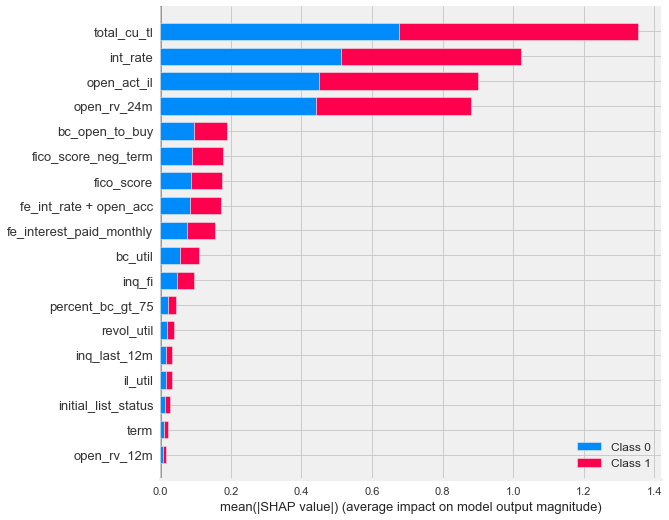

In [50]:
#plot summary feature importance
shap.summary_plot(shap_values, X_test_2019, plot_type="bar")

In [63]:
helpers.data_dictionary(['total_cu_tl'])
helpers.data_dictionary(['open_act_il'])

,feature,Description
103,total_cu_tl,Number of finance trades


,feature,Description
77,open_act_il,Number of currently active installment trades


The most predictive feature based on the plot above is total_cu_tl with the definition show above <br>
The second  is interest rate which intuitively makes sense. High interest rates means the individual will pay more over time <br>
The third is the number of active installment trades. 

In [51]:
instance_to_explain = 0
shap.force_plot(explainer.expected_value[1], shap_values[1][instance_to_explain], X_test_2019.iloc[instance_to_explain])

Force plots allow visualization of each prediction and what factors contributed to positive or negative classification <br>
Features pushing the prediction higher away from the base value are shown in red while those pushing the prediction lower are in blue. <br>
In addition, the size of the boxes show how siginificant the feature was to the overall prediction. In the example above, the number of finance trades (total_cu_tl) <br>
seems to the most predictive feature for this speicific prediction with individual having a large number of trades on their record

<h3> <b> References <b> </h3>

<p> Beyeler, M. (2017) 'Machine Learning for OpenCV' Packt Publishing 2017 </p>
<p> Brownlee, J. (2019) 'Machine Learning Mastery with Python' 
<p> Boschetti A and Massaron L (2018). 'Python Data Science Essentials: 3rd Edition' Packt Publishing  </p>
<p> Burkov, A. (2019). 'The Hundred-Page Machine Learning Book' Publisher: Andriy Burkov </p>
<p> Christoph,M (2019) 'Interpretable Machine Learning' Available at: https://christophm.github.io/interpretable-ml-book/shap.html (Accessed: December 13th, 2019)
<p> Stefan, J. (2018) 'Hands-On Machine Learning for Algorithmic Trading'. Packt Publishing 2018 </p>
<p> Zheng A & Casari A. (2018). 'Feature Engineering for Machine Learning' Sebastopol, CA: O'Reilly Publishing </p>